# Tutorial

This notebook is the tutorial and user guide for the algorithm implemented in https://github.com/BoxiLi/repeater-cut-off-optimization.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from repeater_algorithm import plot_algorithm, RepeaterChainSimulation

## Entanglement swap
In the following example, we simulate a swap protocol of three nodes, where the middle one is a repeater.

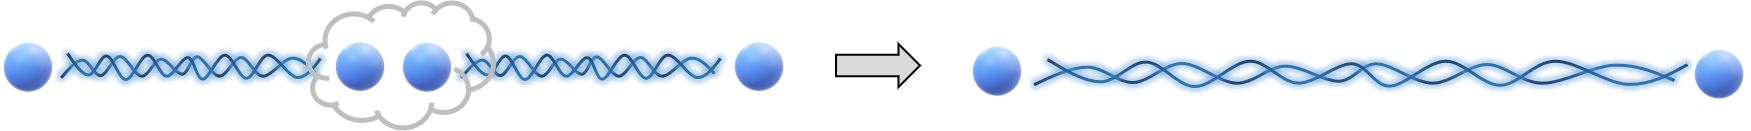

First, we define the following parameters for the simulation:
- `protocol`: Asymmetric protocol is represented by a tuple of 0 and 1, where 0 stands for swap and 1 stands for distillation. In this example we have only one entanglement swapping, hence it is a single-element tuple `(0,)`;
- `p_gen`: The success probability of direct entanglement generation between two adjacent nodes;
- `p_swap`: The success probability of entanglement swapping;
- `w0`: The initial Werner parameter of the state. Since we use the Werner state as representation, the Werner parameter fully determines the two-qubit quantum state.
- `t_coh`: The coherence time of the entangled qubits in quantum memories. The Werner parameter decreases exponentially according to this time scale. The time unit is the time used in one attempt of direct entanglement generation.
- `t_trunc`: The truncation time of the simulation. It should be chosen large enough so that the almost all probability distribution (>99%) is included.

In [15]:
parameters = {
    "protocol": (0,),
    "p_gen": 0.01,
    "p_swap": 0.5,
    "w0": 0.8,  # fidelity 0.85
    "t_coh": 1500,
    "t_trunc": 3000,
}

In [16]:
# Initialize simulator
simulator = RepeaterChainSimulation()
# compute the waiting time distribution and the time-dependent Werner parameter
pmf, w_func = simulator.nested_protocol(parameters)

### Time distribution
We can plot the distribution of obtaining the end-to-end entanglement:

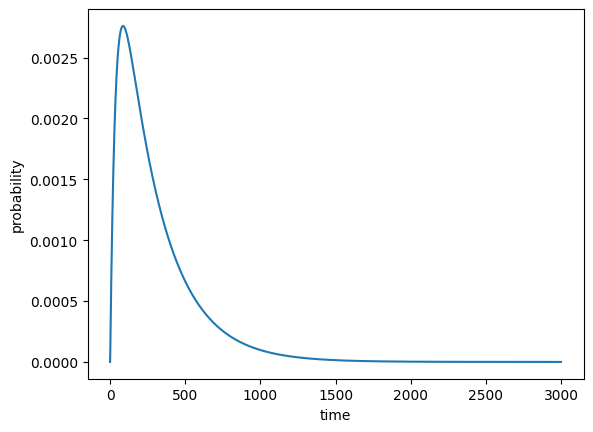

In [17]:
plt.plot(pmf)
plt.xlabel("time")
plt.ylabel("probability")
plt.show()

The plot above shows the waiting time distribution of this three-node swap protocol. In the first few time steps, the probability is very low because the two direct entangled pairs are note prepared. The distribution peaks around 200.

We can compute the probability mass that is covered by this distribution

In [18]:
np.sum(pmf)

0.9999879933142144

We can also calculate the average waiting time and compare it with the analytical result.

In [19]:
# numerical
from utility_functions import get_mean_waiting_time
numerical_result = get_mean_waiting_time(pmf)
# analytical
p_gen = parameters["p_gen"]
p_swap = parameters["p_swap"]
analytical_result = (3-2*p_gen)/((2-p_gen)*p_gen*p_swap)

print("Numerical result:", numerical_result)
print("Analytical result:", analytical_result)

Numerical result: 299.49795473146975
Analytical result: 299.4974874371859


### Fidelity
Same as the waiting time, we cal also plot the quality of the entanglement as a function of time. Here, we use `werner_to_fid` and `fid_to_werner` to transfer between the Werner parameter and the fidelity. Notice that the first few steps might be inaccurate because their probability is so small that leads to numerical instability. 

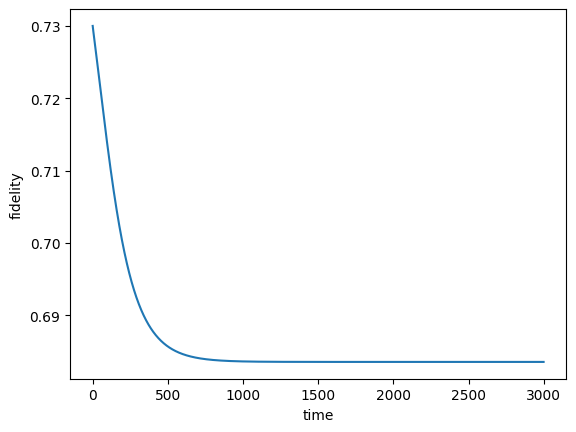

In [20]:
from utility_functions import werner_to_fid
w_func[:1] = np.nan  # remove instable part
plt.plot(werner_to_fid(w_func))
plt.xlabel("time")
plt.ylabel("fidelity")
plt.show()

We see from the above figure that, due to memory decay, the later the entanglement is produced, the lower is its fidelity. Since we neglect other noise in the quantum operation, we can in principle obtain a perfect entanglement at time step 1, although the probability is extremely low. We compute the average fidelity:

In [21]:
from utility_functions import get_mean_werner, werner_to_fid
werner_to_fid(get_mean_werner(pmf, w_func))

0.7001416234013129

## Entanglemen distillation/purification
Entanglement distillation is used to improve the fidelity of entangled qubits e.g. by merging two entangled pairs followed by postselection.

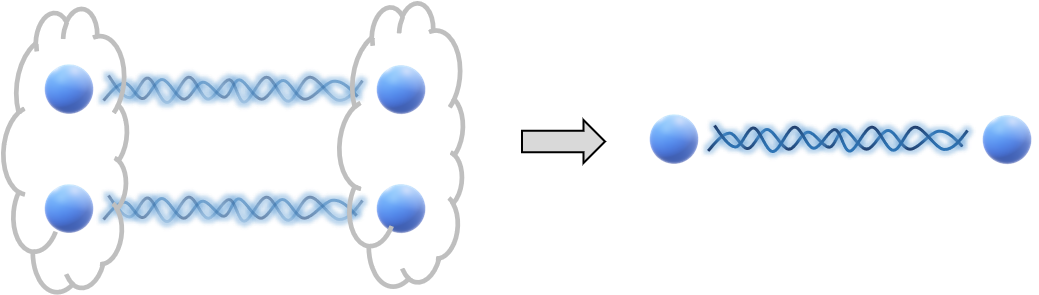

Here we use the [BBPSSW](https://arxiv.org/abs/quant-ph/9511027) distillation protocol. Distillation is represented by 1 in our protocol. We add a distillation on top of the swap protocol we've plotted above. The whole protocol now has 3 nodes. Two pairs of qubits will be first entangled by swapping in parallel. After they are both prepared, the distillation is executed.

In [22]:
parameters["protocol"] = (1,)

In [23]:
pmf, w_func = simulator.nested_protocol(parameters)
print("Average waiting time", get_mean_waiting_time(pmf))
print("Average fidelity", werner_to_fid(get_mean_werner(pmf, w_func)))

Average waiting time 187.1638718781278
Average fidelity 0.8672694353330785


## Cut-off

Cut-off set a limit on the entanglement distribution process. For instance, usually, one entangled pair is usually generated and stored in the quantum memory, waiting for the other pair to be prepared. The fidelity decays during the storage because of noise. Sometimes, it is beneficial to set a limit on the storage time. If the storage time exceeds the threshold. The process is terminated and restarts from entanglement generation between adjacent nodes.

Here we use the 3-node swap protocol again, but now with a cut-off. Because cut-off is only effective for small coherence time. We modify the parameters for this comparison.

We can use `list` in parameters and `create_iter_ikwargs` to iterate over different cutoff values.

In [24]:
parameters = {
    "protocol": (0,),
    "p_gen": 0.01,
    "p_swap": 0.5,
    "w0": 0.98,  # fidelity 0.95
    "t_coh": 300,
    "t_trunc": 3000,
    "cut_type": "memory_time",
    "cutoff": [1000000, 50],
}

from logging_utilities import create_iter_kwargs
parameters_list = create_iter_kwargs(parameters)
print("First parameter set")
print(parameters_list[0])
print("Second parameter set")
print(parameters_list[1])

pmf1, w_func1 = simulator.nested_protocol(parameters_list[0])
pmf2, w_func2 = simulator.nested_protocol(parameters_list[1])

First parameter set
{'protocol': (0,), 'p_gen': 0.01, 'p_swap': 0.5, 'w0': 0.98, 't_coh': 300, 't_trunc': 3000, 'cut_type': 'memory_time', 'cutoff': 1000000}
Second parameter set
{'protocol': (0,), 'p_gen': 0.01, 'p_swap': 0.5, 'w0': 0.98, 't_coh': 300, 't_trunc': 3000, 'cut_type': 'memory_time', 'cutoff': 50}


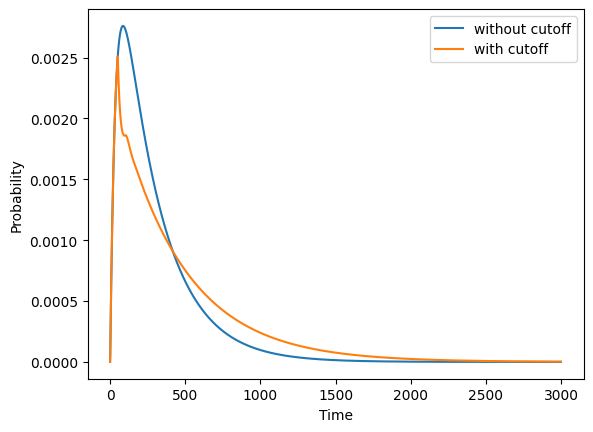

Average waiting time without cutoff 299.49795473146975
Average waiting time with cutoff 449.987210586406


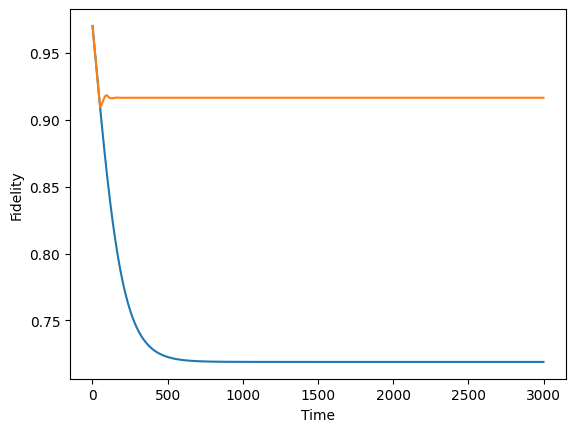

Average fidelity without cutoff 0.7909066449296419
Average fidelity with cutoff 0.9176504794686844


In [25]:
tlist = np.arange(parameters["t_trunc"])
plt.plot(tlist, pmf1, tlist, pmf2)
plt.legend(("without cutoff", "with cutoff"))
plt.xlabel("Time")
plt.ylabel("Probability")
plt.show()
print("Average waiting time without cutoff", get_mean_waiting_time(pmf1))
print("Average waiting time with cutoff", get_mean_waiting_time(pmf2))

w_func1[:1] = np.nan
w_func2[:1] = np.nan
plt.plot(tlist, werner_to_fid(w_func1), tlist, werner_to_fid(w_func2))
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.show()
print("Average fidelity without cutoff", werner_to_fid(get_mean_werner(pmf1, w_func1)))
print("Average fidelity with cutoff", werner_to_fid(get_mean_werner(pmf2, w_func2)))

## High-level symmetric protocols
The code offers a simple way to define nested symmetric protocols. In these protocols, the two entangled pairs used in swap or distillation at higher levels are produced by the same protocol used to generate current-level entanglement. For instance, a protocol with 9 nodes and 8 segments that executes 3 rounds of entanglement swapping can be defined by

average waiting time: 3072.4120380656136


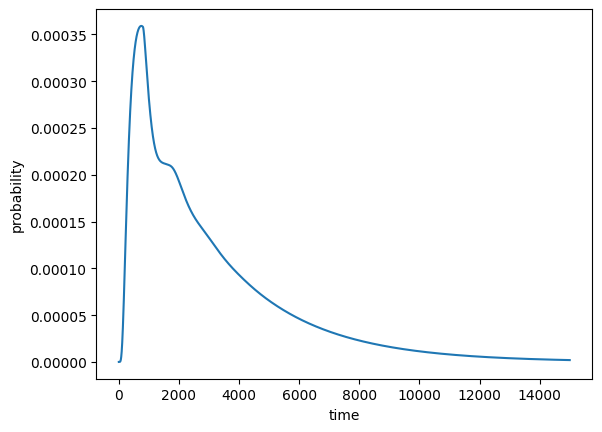

In [26]:
parameters = {
    "protocol": (0, 0, 0,),
    "p_gen": 0.01,
    "p_swap": 0.5,
    "w0": 1.,
    "t_coh": 8000,
    "mt_cut": 800,
    "t_trunc": 15000,
}

simulator = RepeaterChainSimulation()
pmf, w_func = simulator.nested_protocol(parameters)
print("average waiting time:", get_mean_waiting_time(pmf))
plt.plot(pmf)
plt.xlabel("time")
plt.ylabel("probability")
plt.show()

Another example includes dsitillation

average waiting time: 2536.680896270985


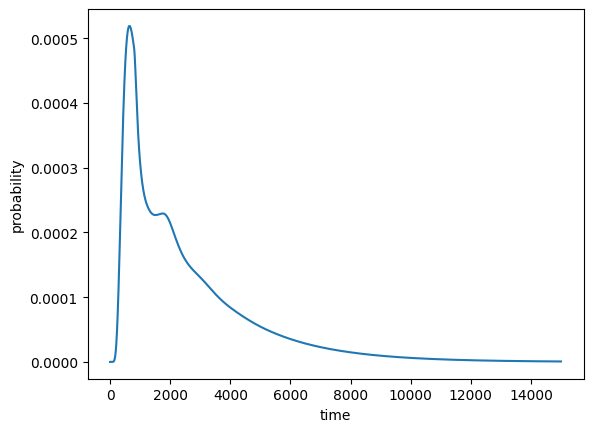

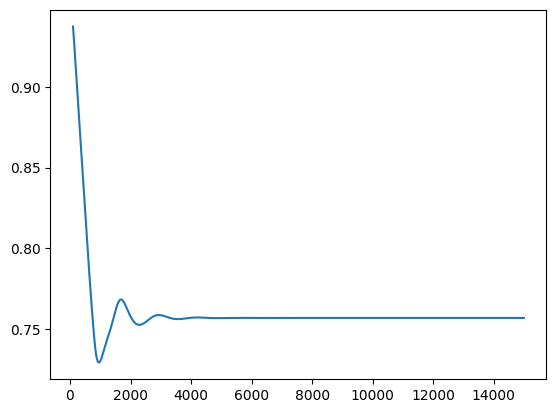

In [27]:
parameters = {
    "protocol": (0, 1, 1, 0,),
    "p_gen": 0.01,
    "p_swap": 0.5,
    "w0": 0.98,
    "t_coh": 3000,
    "mt_cut": 800,
    "t_trunc": 15000,
}

simulator = RepeaterChainSimulation()
pmf, w_func = simulator.nested_protocol(parameters)
print("average waiting time:", get_mean_waiting_time(pmf))
plt.plot(pmf)
plt.xlabel("time")
plt.ylabel("probability")
plt.show()
w_func[:100] = np.nan
plt.plot(w_func)

## Optimization of cut-offs

The optimization using differential evolution algorithm is implemented in the class `CutoffOptimizer`.

In [28]:
from optimize_cutoff import CutoffOptimizer
parameters = {
    "protocol": (0,),
    "p_gen": 0.01,
    "p_swap": 0.5,
    "w0": 0.98,  # fidelity 0.95
    "t_coh": 300,
    "t_trunc": 3000,
    "cut_type": "memory_time",
}

# We use the logging system to show the information
import logging
from logging_utilities import log_init
log_init("cutoff_optimze", level=logging.INFO)

optimizer = CutoffOptimizer(adaptive=True)
optimizer.run(parameters)

INFO:root:ID: cutoff_optimze-20240424-163845
INFO:root:Date: 2024-04-24 16:38:45

INFO:root:-------------------------------------------
INFO:root:Optimization of the cut-off time

INFO:root:Parameters:
protocol (0,)
p_gen 0.01
p_swap 0.5
w0 0.98
t_coh 300
t_trunc 3000
cut_type memory_time

INFO:root:Pretraining begins...
INFO:root:Pretraining finishes, reference pmf obtained.


differential_evolution step 1: f(x)= -0.0012975453570754612
current cut-off location [0.47633412]
convergence: 0.07627852262901355
differential_evolution step 2: f(x)= -0.0012975453570754612
current cut-off location [0.47633412]
convergence: 0.9102875162027859
differential_evolution step 3: f(x)= -0.0012975453570754612
current cut-off location [0.47633412]
convergence: 1.7162350170077518
Polishing solution with 'L-BFGS-B'


INFO:root:Local optimal check fails. The cut-off found is not optimal. Neighboring cut-off {'memory_time': array([64])} is better with an increase in the secrete key rate of 0.003%.

INFO:root:The current cut-off found: {'memory_time': array([65])}
The current cut-off is located at: [0.47633412]
The current key rate is 0.0012975453570754612
INFO:root:The following change has been made to the parameters:
INFO:root:'popsize' is increased to 15.
INFO:root:Search region for cutoff[0] is restricted to (20,151).
INFO:root:Optimization fails to find the best cut-off. Restarting.



differential_evolution step 1: f(x)= -0.0012975453570754612
current cut-off location [0.49402848]
convergence: 0.047976711762797976
differential_evolution step 2: f(x)= -0.0012975790943441816
current cut-off location [0.48858526]
convergence: 0.10807147271794508
differential_evolution step 3: f(x)= -0.0012975790943441816
current cut-off location [0.48858526]
convergence: 0.5241032350903141
differential_evolution step 4: f(x)= -0.0012975790943441816
current cut-off location [0.48858526]
convergence: 2.409204295239702
Polishing solution with 'L-BFGS-B'


INFO:root:The best cut-off found: {'memory_time': array([64])}
The best cut-off is located at: [0.48858526]
The best key rate is 0.0012975790943441816

INFO:root:-------------------------------------------


{'memory_time': array([64])}

The optimal cutoff is `cutoff=64`.

We now perform an optimization on a 3-level swapping protocol.

In [29]:
from optimize_cutoff import CutoffOptimizer
parameters = {
    "protocol": (0, 0, 0),
    "p_gen": 0.01,
    "p_swap": 0.5,
    "w0": 0.98,  # fidelity 0.95
    "t_coh": 4000,
    "t_trunc": 30000,
    "cut_type": "memory_time",
}
optimizer = CutoffOptimizer(adaptive=True)
optimizer.run(parameters)

INFO:root:-------------------------------------------
INFO:root:Optimization of the cut-off time

INFO:root:Parameters:
protocol (0, 0, 0)
p_gen 0.01
p_swap 0.5
w0 0.98
t_coh 4000
t_trunc 30000
cut_type memory_time

INFO:root:Pretraining begins...
INFO:root:Pretraining finishes, reference pmf obtained.


differential_evolution step 1: f(x)= -3.0714635079629115e-05
current cut-off location [0.73760534 0.65606013 0.60858312]
convergence: 0.019349569849284137
differential_evolution step 2: f(x)= -3.088020291178228e-05
current cut-off location [0.80275615 0.63297852 0.61455842]
convergence: 0.034461528402362475
differential_evolution step 3: f(x)= -3.18228592644689e-05
current cut-off location [0.87410506 0.59451086 0.53313999]
convergence: 0.04509493626921541
differential_evolution step 4: f(x)= -3.249006745529193e-05
current cut-off location [0.84024069 0.6024796  0.47185367]
convergence: 0.13577909642521407
differential_evolution step 5: f(x)= -3.249006745529193e-05
current cut-off location [0.84024069 0.6024796  0.47185367]
convergence: 0.1769034620566942
differential_evolution step 6: f(x)= -3.2619829401637784e-05
current cut-off location [0.83481398 0.62277367 0.4235625 ]
convergence: 0.25042394335890067
differential_evolution step 7: f(x)= -3.263309693943546e-05
current cut-off loca

INFO:root:Local optimal check fails. The cut-off found is not optimal. Neighboring cut-off {'memory_time': array([179, 304, 565])} is better with an increase in the secrete key rate of 0.055%.

INFO:root:The current cut-off found: {'memory_time': array([182, 301, 568])}
The current cut-off is located at: [0.83869931 0.62946337 0.44354633]
The current key rate is 3.267438000167884e-05
INFO:root:The following change has been made to the parameters:
INFO:root:'popsize' is increased to 15.
INFO:root:Search region for cutoff[0] is restricted to (77,30001).
INFO:root:Search region for cutoff[1] is restricted to (144,735).
INFO:root:Search region for cutoff[2] is restricted to (238,1137).
INFO:root:Optimization fails to find the best cut-off. Restarting.



differential_evolution step 1: f(x)= -3.271536096489398e-05
current cut-off location [0.61835289 0.58326889 0.45924559]
convergence: 0.024147949832608435
differential_evolution step 2: f(x)= -3.271536096489398e-05
current cut-off location [0.61835289 0.58326889 0.45924559]
convergence: 0.03564619779159397
differential_evolution step 3: f(x)= -3.271536096489398e-05
current cut-off location [0.61835289 0.58326889 0.45924559]
convergence: 0.045807013335069764
differential_evolution step 4: f(x)= -3.271536096489398e-05
current cut-off location [0.61835289 0.58326889 0.45924559]
convergence: 0.07066994190029449
differential_evolution step 5: f(x)= -3.271536096489398e-05
current cut-off location [0.61835289 0.58326889 0.45924559]
convergence: 0.19366597900075172
differential_evolution step 6: f(x)= -3.272275910805343e-05
current cut-off location [0.61512535 0.55844438 0.45901542]
convergence: 0.2307011919649953
differential_evolution step 7: f(x)= -3.272392600245449e-05
current cut-off locat

INFO:root:Local optimal check fails. The cut-off found is not optimal. Neighboring cut-off {'memory_time': array([177, 327, 558])} is better with an increase in the secrete key rate of 0.004%.

INFO:root:The current cut-off found: {'memory_time': array([177, 330, 558])}
The current cut-off is located at: [0.63093004 0.5610132  0.48370323]
The current key rate is 3.274180390585927e-05
INFO:root:The following change has been made to the parameters:
INFO:root:'popsize' is increased to 22.
INFO:root:Search region for cutoff[0] is restricted to (117,356).
INFO:root:Search region for cutoff[1] is restricted to (215,539).
INFO:root:Search region for cutoff[2] is restricted to (349,845).
INFO:root:Optimization fails to find the best cut-off. Restarting.



differential_evolution step 1: f(x)= -3.265668586062765e-05
current cut-off location [0.48303883 0.58394208 0.43988848]
convergence: 0.003161687641278365
differential_evolution step 2: f(x)= -3.272751667884284e-05
current cut-off location [0.48803969 0.45783537 0.47114377]
convergence: 0.0031964911864565035
differential_evolution step 3: f(x)= -3.272751667884284e-05
current cut-off location [0.48803969 0.45783537 0.47114377]
convergence: 0.030134582056162353
differential_evolution step 4: f(x)= -3.2736243687801735e-05
current cut-off location [0.50507607 0.48915171 0.52221252]
convergence: 0.06102112261730101
differential_evolution step 5: f(x)= -3.2736243687801735e-05
current cut-off location [0.50507607 0.48915171 0.52221252]
convergence: 0.06918487885726765
differential_evolution step 6: f(x)= -3.2736243687801735e-05
current cut-off location [0.50507607 0.48915171 0.52221252]
convergence: 0.11001107451104435
differential_evolution step 7: f(x)= -3.2736243687801735e-05
current cut-of

INFO:root:The best cut-off found: {'memory_time': array([176, 325, 563])}
The best cut-off is located at: [0.49212724 0.48015901 0.50550427]
The best key rate is 3.274281249923561e-05

INFO:root:-------------------------------------------


{'memory_time': array([176, 325, 563])}

The best cutoff time on each level is different.

One can also force all the cutoff time to be the same.

In [30]:
optimizer = CutoffOptimizer(adaptive=True, opt_kind="uniform_de")
optimizer.run(parameters)

INFO:root:-------------------------------------------
INFO:root:Optimization of the cut-off time

INFO:root:Parameters:
protocol (0, 0, 0)
p_gen 0.01
p_swap 0.5
w0 0.98
t_coh 4000
t_trunc 30000
cut_type memory_time

INFO:root:Pretraining begins...
INFO:root:Pretraining finishes, reference pmf obtained.


differential_evolution step 1: f(x)= -2.9282934151797967e-05
current cut-off location [0.04841994]
convergence: 0.011289050514664561
differential_evolution step 2: f(x)= -2.9282934151797967e-05
current cut-off location [0.04841994]
convergence: 0.013941696579604345
differential_evolution step 3: f(x)= -2.9509223399820884e-05
current cut-off location [0.03799654]
convergence: 0.05339951072165253
differential_evolution step 4: f(x)= -2.9509223399820884e-05
current cut-off location [0.03799654]
convergence: 0.11687812406023601
differential_evolution step 5: f(x)= -2.9509223399820884e-05
current cut-off location [0.03799654]
convergence: 0.447800952151148
differential_evolution step 6: f(x)= -2.9509223399820884e-05
current cut-off location [0.03799654]
convergence: 3.2676713554316916
Polishing solution with 'L-BFGS-B'


INFO:root:The best cut-off found: {'memory_time': array([371, 371, 371])}
The best cut-off is located at: [0.03799654]
The best key rate is 2.9509223399820884e-05

INFO:root:-------------------------------------------


{'memory_time': array([371, 371, 371])}

## Logging system and data saving

## Asymmetric protocols and advanced use

## Density matrix representation